In [1]:
## Transform fruit coordinates obtained from a point cloud to all positive x, y, and z-coordinates.
import csv  
import numpy as np
import math

%matplotlib notebook        
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # plot in 3D

from scipy.spatial.transform import Rotation as R
from scipy.linalg import lstsq

# from skspatial.objects import Line
# from skspatial.objects import Points
# from skspatial.plotting import plot_3d

In [2]:
csv_file = './TREE_FRUIT_DATA/1067_apple.csv'

x_list = list()
y_list = list()
z_list = list()

numFruit = 0
        
with open(csv_file) as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    for row in reader:
        # need to check that x, y, z, coordinates match my definition of x, y, z -> apples 2015 do
        x_list.append(row[0])
        y_list.append(row[1])
        z_list.append(row[2])
        
# print(x_list)
print('the number of fruits:', len(x_list))

# convert list to array
x_pointcloud = np.array(x_list)
y_pointcloud = np.array(y_list)
z_pointcloud = np.array(z_list)

# find the min and max values for each
x_min = np.amin(x_pointcloud)
x_max = np.amax(x_pointcloud)
y_min = np.amin(y_pointcloud)
y_max = np.amax(y_pointcloud)
z_min = np.amin(z_pointcloud)
z_max = np.amax(z_pointcloud)

print('the min and max for the x-coord:', x_min, x_max)
print('the min and max for the y-coord:', y_min, y_max)
print('the min and max for the z-coord:', z_min, z_max)

the number of fruits: 1183
the min and max for the x-coord: -12.539755821228 6.54281044006348
the min and max for the y-coord: -1.27894973754883 1.42552351951599
the min and max for the z-coord: -3.1274561882019 -0.344772964715958


In [3]:
## Linear transformations so that all values are positive
x_p_pointcloud = x_pointcloud + abs(x_min)
y_p_pointcloud = y_pointcloud + abs(y_min)
z_p_pointcloud = z_pointcloud + abs(z_min)

x_min = np.amin(x_p_pointcloud)
x_max = np.amax(x_p_pointcloud)
y_min = np.amin(y_p_pointcloud)
y_max = np.amax(y_p_pointcloud)
z_min = np.amin(z_p_pointcloud)
z_max = np.amax(z_p_pointcloud)

print('the min and max for the x-coord:', x_min, x_max)
print('the min and max for the y-coord:', y_min, y_max)
print('the min and max for the z-coord:', z_min, z_max)

the min and max for the x-coord: 0.0 19.082566261291483
the min and max for the y-coord: 0.0 2.7044732570648202
the min and max for the z-coord: 0.0 2.7826832234859418


In [4]:
## Normalization to meters based on Fuji apple sizes (from Juan Villacres' calculations)
x_m = (x_p_pointcloud - x_p_pointcloud.min()) / (x_p_pointcloud.max() - x_p_pointcloud.min()) * 16.2
y_m = (y_p_pointcloud - y_p_pointcloud.min()) / (y_p_pointcloud.max() - y_p_pointcloud.min()) * 1.35
z_m = (z_p_pointcloud - z_p_pointcloud.min()) / (z_p_pointcloud.max() - z_p_pointcloud.min()) 

x_min = np.amin(x_m)
x_max = np.amax(x_m)
y_min = np.amin(y_m)
y_max = np.amax(y_m)
z_min = np.amin(z_m)
z_max = np.amax(z_m)

print('the min and max for the x-coord:', x_min, x_max)
print('the min and max for the y-coord:', y_min, y_max)
print('the min and max for the z-coord:', z_min, z_max)

the min and max for the x-coord: 0.0 16.2
the min and max for the y-coord: 0.0 1.35
the min and max for the z-coord: 0.0 1.0


In [5]:
## Rotation and Plane equation functions

#  3D best fit plane of the points/pointcloud
# https://math.stackexchange.com/questions/99299/best-fitting-plane-given-a-set-of-points
# do fit
def points2plane(x, y, z):
    '''
       Fit plane to points in 3D and return the fit (plane equation values for 
       z = fit[0]x + fit[1]y + fit[2])
    '''
    tmp_A = []
    tmp_b = []
    for i in range(len(x)):
        tmp_A.append([x[i], y[i], 1])
        tmp_b.append(z[i])

    b = np.matrix(tmp_b).T
    A = np.matrix(tmp_A)

    fit, residual, rnk, s = lstsq(A, b)
    errors = b - A * fit

    print("solution: %f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))
    print("errors: \n", errors)
    print("residual:", residual)
    
    return(fit)


# Rotate the data by aligning the skewed direction vector with a desired vector
# https://stackoverflow.com/questions/45142959/calculate-rotation-matrix-to-align-two-vectors-in-3d-space
def get_rotation_matrix(vec2, vec1=np.array([1, 0, 0])): 
    # other code was resulting in nan due to the desired (0,0,0) normal vector
    """get rotation matrix between two vectors using scipy"""
    vec1 = np.reshape(vec1, (1, -1))
    vec2 = np.reshape(vec2, (1, -1))
    r = R.align_vectors(vec2, vec1)
    return r[0].as_matrix()


# Rotate data by number of degrees in 3D
# https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
# https://stackoverflow.com/questions/18789232/rotate-a-3d-object-in-python
def rotate_Zaxis(deg):
    '''Rotate by desired degrees around the z-axis, returns required transform matrix'''
    theta = np.radians(deg)
    
    matrix = np.array([[math.cos(theta), -math.sin(theta), 0], 
                       [math.sin(theta),  math.cos(theta), 0],
                       [0,                0,               1]])
    
    print('around z-axis rotation matrix:\n',matrix)
    print()

    return(matrix)
    
    
# came up at some point https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula

In [6]:
#  3D best fit line of the points/pointcloud and rotation based on desired normal vector
fit = points2plane(x_m, y_m, z_m)
print(fit)
print()

vec1 = np.array([fit[0,0], fit[1,0], -1])
# want it to be parallel and on to the XY-plane
vec2 = np.array([-1,0,0])
print('  plane\'s normal vector\n', vec1)
print('')
print('  plane\'s desired vector\n', vec2)
print()

mat = get_rotation_matrix(vec1=vec1, vec2=vec2)
print('rotation matrix:\n', mat)
# vec1_rot = mat.dot(vec1)
# assert np.allclose(vec1_rot / np.linalg.norm(vec1_rot), vec2 / np.linalg.norm(vec2))

points        = np.stack((x_m, y_m, z_m), axis=-1)
rotato_potato = mat.dot(points.T)

## Second rotation


solution: 0.051143 x + 0.085678 y + 0.064185 = z
errors: 
 [[ 0.00432091]
 [-0.00780746]
 [-0.01044232]
 ...
 [ 0.06829077]
 [-0.0002337 ]
 [-0.04699386]]
residual: [1.43736285]
[[0.05114266]
 [0.0856782 ]
 [0.06418468]]

  plane's normal vector
 [ 0.05114266  0.0856782  -1.        ]

  plane's desired vector
 [-1  0  0]

rotation matrix:
 [[-5.08899537e-02 -8.52548365e-02  9.95058705e-01]
 [ 9.98704267e-01 -4.34424366e-03  5.07041905e-02]
 [-1.11022302e-16  9.96349708e-01  8.53654474e-02]]


/home/natapueyo/miniconda3/envs/wall_2020/lib/python3.7/site-packages/scipy/spatial/transform/rotation.py:1967: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  warnings.warn("Optimal rotation is not uniquely or poorly defined "


<IPython.core.display.Javascript object>


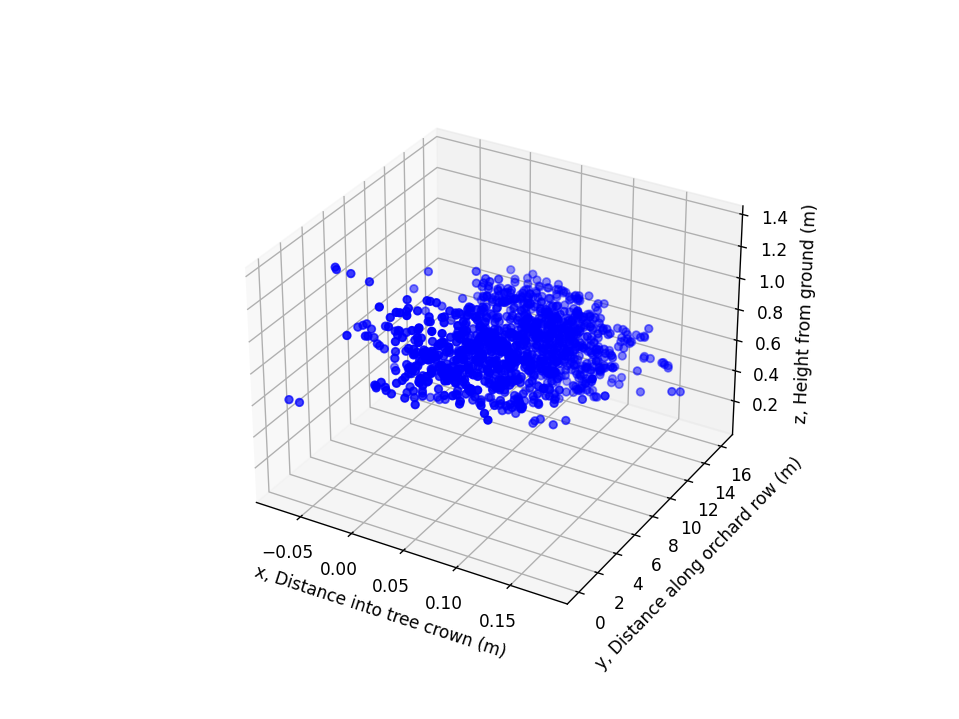

In [7]:
## plot of first rotation transformation of data to remove incorrect angles

# plot rotato potato
plt.figure()
ax = plt.subplot(111, projection='3d')
# ax.scatter(x_m, y_m, z_m, color='k')
ax.scatter(rotato_potato[0], rotato_potato[1], rotato_potato[2], color='b')

ax.set_xlabel('x, Distance into tree crown (m)')
ax.set_ylabel('y, Distance along orchard row (m)')
ax.set_zlabel('z, Height from ground (m)')
plt.show()


In [8]:
#  2nd 3D best fit line of the points/pointcloud and rotation
fit_rp = points2plane(rotato_potato[0], rotato_potato[1], rotato_potato[2])
print(fit_rp)
print()

vec1_0 = np.array([fit_rp[0,0], fit_rp[1,0], -1])
vec2_0 = np.array([0,0,-1])

print('  plane\'s normal vector\n', vec1_0)
print('')
print('  plane\'s desired vector\n', vec2_0)
print()

mat_0 = get_rotation_matrix(vec1=vec1_0, vec2=vec2_0)
print('rotation matrix:\n', mat_0)
# vec1_rot = mat.dot(vec1)
# assert np.allclose(vec1_rot / np.linalg.norm(vec1_rot), vec2 / np.linalg.norm(vec2))

# points        = np.stack((rotato_potato[0], rotato_potato[1], rotato_potato[2]), axis=-1)
rotato_potato0 = mat_0.dot(rotato_potato)

# y-axis is too short compared to what it should be, normalize and stretch
rotato_potato0[2] = (rotato_potato0[2] - rotato_potato0[2].min()) / (rotato_potato0[2].max() - rotato_potato0[2].min()) * 1.35

solution: 0.087826 x + -0.039973 y + 1.090123 = z
errors: 
 [[ 0.21506022]
 [ 0.21358034]
 [ 0.14968398]
 ...
 [-0.03846501]
 [-0.07654551]
 [-0.06533807]]
residual: [36.52315497]
[[ 0.08782622]
 [-0.03997296]
 [ 1.09012315]]

  plane's normal vector
 [ 0.08782622 -0.03997296 -1.        ]

  plane's desired vector
 [ 0  0 -1]

rotation matrix:
 [[ 1.11022302e-16 -9.99202037e-01  3.99410667e-02]
 [ 9.96171529e-01  3.49165466e-03  8.73504075e-02]
 [-8.74201655e-02  3.97881534e-02  9.95376621e-01]]


<IPython.core.display.Javascript object>


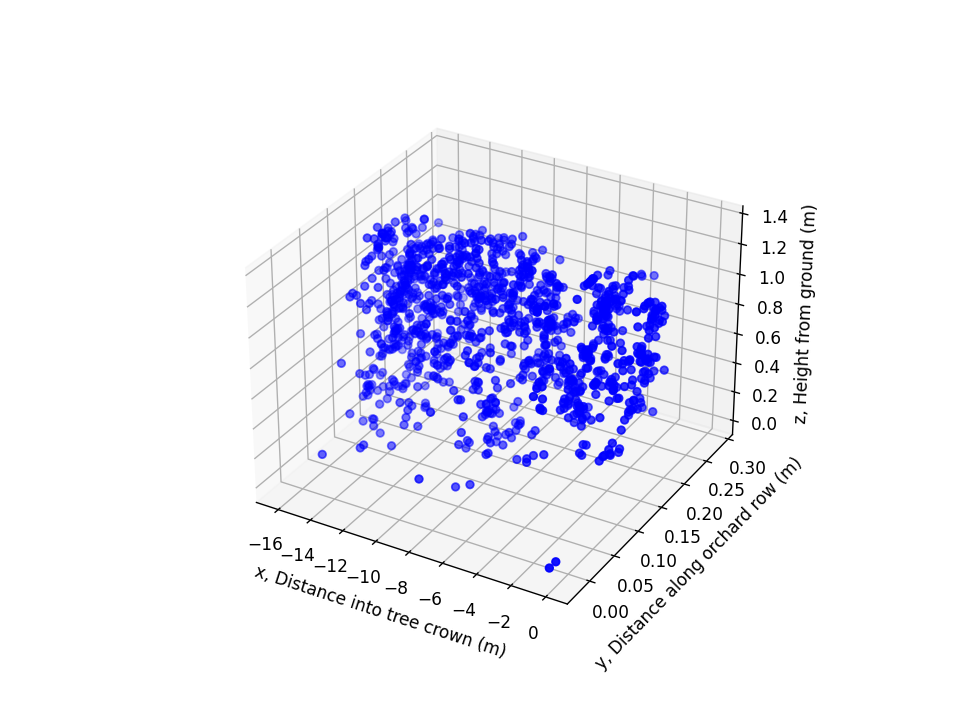

In [9]:
## Rotation transformation of data to remove incorrect angles
# plot rotato potato (2nd rotation)
plt.figure()
ax = plt.subplot(111, projection='3d')
# ax.scatter(x_m, y_m, z_m, color='k')
ax.scatter(rotato_potato0[0], rotato_potato0[1], rotato_potato0[2], color='b')

ax.set_xlabel('x, Distance into tree crown (m)')
ax.set_ylabel('y, Distance along orchard row (m)')
ax.set_zlabel('z, Height from ground (m)')
plt.show()


around z-axis rotation matrix:
 [[-1.8369702e-16  1.0000000e+00  0.0000000e+00]
 [-1.0000000e+00 -1.8369702e-16  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]



<IPython.core.display.Javascript object>


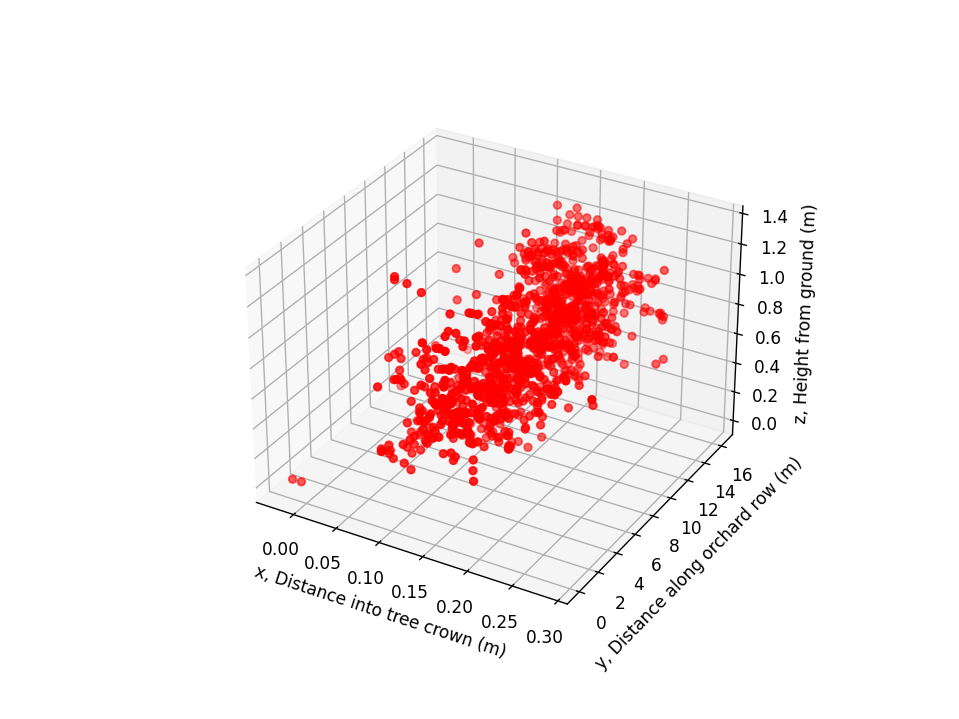

In [10]:
## last bit needs to be rotated around the z-axis 
deg = 270 # in degrees 

z_transform_mat = rotate_Zaxis(deg)
final_points    = z_transform_mat.dot(rotato_potato0)

# plot final transformation (3nd rotation around z-axis)
plt.figure()
ax = plt.subplot(111, projection='3d')
# ax.scatter(x_m, y_m, z_m, color='k')
ax.scatter(final_points[0], final_points[1], final_points[2], color='r')

ax.set_xlabel('x, Distance into tree crown (m)')
ax.set_ylabel('y, Distance along orchard row (m)')
ax.set_zlabel('z, Height from ground (m)')
plt.show()


In [11]:
## Write the new, transformed coordinates into a CSV file
import csv
from datetime import date

# date object of today's date
today = date.today() 

# print("Current year:", today.year)
# print("Current month:", today.month)
# print("Current day:", today.day)
# print()

if today.month < 10:
    month = str(0) + str(today.month)
else:
    month = str(today.month)

date_today = str(today.year) + month + str(today.day)

file_name = './TREE_FRUIT_DATA/' + date_today + '_apples_Juan.csv'
print('file name:', file_name)
print()

to_csv = final_points.T

with open(file_name, mode='w') as apple_file:
    apple_wr = csv.writer(apple_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    for coord in to_csv:
        apple_wr.writerow(coord)
        
    print('CSV', csv_file, 'transformed and written into', file_name, 'with', len(final_points[0]), 'points')



file name: ./TREE_FRUIT_DATA/20220811_apples_Juan.csv

CSV ./TREE_FRUIT_DATA/1067_apple.csv transformed and written into ./TREE_FRUIT_DATA/20220811_apples_Juan.csv with 1183 points
